## Lib


In [1]:
import torch
# torch.cuda.set_device(8)

In [2]:
from baselines.ViT.ViT_explanation_generator import Baselines

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from samples.CLS2IDX import CLS2IDX

In [3]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_for_cam
from baselines.ViT.ViT_explanation_generator import LRP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

model = vit_for_cam(pretrained=True).to(device)
baselines = Baselines(model)

# initialize ViT pretrained
model = vit_base_patch16_224(pretrained=True).to(device)
model.eval()
attribution_generator = LRP(model)

name_map_baselines = {
    "VTA":'transformer_attribution', "FLRP":"full", 'PFRP':"last_layer", "raw_attn":"attn_last_layer", 'rollout':"rollout", "GradCAM":"attn_gradcam"
}

def gen_grad_cam(baselines, index, image):
    output = baselines.model(image.unsqueeze(0).to(device), register_hook=True)
    if index == None:
        index = np.argmax(output.cpu().data.numpy())
    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0][index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.to(device) * output)
    baselines.model.zero_grad()
    one_hot.backward(retain_graph=True)
    grad = baselines.model.blocks[-1].attn.get_attn_gradients()
    cam = baselines.model.blocks[-1].attn.get_attention_map()
    cam = cam[0, :, 0, 1:].reshape(-1, 14, 14)
    grad = grad[0, :, 0, 1:].reshape(-1, 14, 14)
    grad = grad.mean(dim=[1, 2], keepdim=True)
    cam = (cam * grad).mean(0).clamp(min=0)
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

def show_cam_on_image_helper(original_image, transformer_attribution):
    # image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def generate_visualization(original_image, class_index=None, method ="transformer_attribution"):
    importance_maps = get_importance_maps(original_image, class_index, method)
    return show_cam_on_image_helper(original_image, importance_maps)

def get_importance_maps(original_image, class_index=None, method ="transformer_attribution"):
    if method == "attn_gradcam":  
        transformer_attribution = gen_grad_cam(baselines, class_index, original_image).detach()
    else:
        transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).to(device), method=method, index=class_index).detach()
    
    if method=="full":
        transformer_attribution = transformer_attribution.reshape(1, 1, 224, 224)
    else:
        transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
        transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).to(device).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    
    return transformer_attribution

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [4]:
import sys
sys.path.append("./guided-diffusion")
import argparse
import os

import numpy as np
import torch as th
import torch.distributed as dist

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    NUM_CLASSES,
    # model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)

def diffusion_defaults():
    """
    Defaults for image and classifier training.
    """
    return dict(
        learn_sigma=True,
        diffusion_steps=1000,
        noise_schedule="linear",
        timestep_respacing="250",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
    )


def classifier_defaults():
    """
    Defaults for classifier models.
    """
    return dict(
        image_size=256,
        classifier_use_fp16=False,
        classifier_width=128,
        classifier_depth=2,
        classifier_attention_resolutions="32,16,8",  # 16
        classifier_use_scale_shift_norm=True,  # False
        classifier_resblock_updown=True,  # False
        classifier_pool="attention",
    )


def model_and_diffusion_defaults():
    """
    Defaults for image training.
    """
    res = dict(
        image_size=256,
        num_channels=256,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=64,
        attention_resolutions="32,16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=True,
        use_fp16=True,
        use_new_attention_order=False,
    )
    res.update(diffusion_defaults())
    return res


def create_argparser():
    defaults = dict(
        clip_denoised=True,
        num_samples=1,
        batch_size=4,
        use_ddim=False,
        model_path="./guided-diffusion/models/256x256_diffusion_uncond.pt",
    )
    defaults.update(model_and_diffusion_defaults())
    parser = argparse.ArgumentParser()
    add_dict_to_argparser(parser, defaults)
    return parser

args = create_argparser().parse_args([])

dist_util.setup_dist()
logger.configure()

logger.log("creating model and diffusion...")
d_model, diffusion = create_model_and_diffusion(
    **args_to_dict(args, model_and_diffusion_defaults().keys())
)
d_model.load_state_dict(
    dist_util.load_state_dict(args.model_path, map_location="cpu")
)
d_model.to(dist_util.dev())
if args.use_fp16:
    d_model.convert_to_fp16()
d_model.eval()
device = next(d_model.parameters()).device

shape = (1, 3, 256, 256)
steps=1000
start=0.0001
end=0.02

def range_of_delta(beta_s, beta_e, steps):
    def delta_value(beta):
        return (beta/(1-beta))**(0.5)
    return (delta_value(beta_s), delta_value(beta_e))

def beta(t, steps, start, end):
    return (t-1)/(steps-1)*(end-start)+start

def add_noise(x, delta, opt_t, steps, start, end):
    return np.sqrt(1-beta(opt_t, steps, start, end))*(x + th.randn_like(x) * delta)

def get_opt_t(delta, start, end, steps):
    return np.clip(int(np.around(1+(steps-1)/(end-start)*(1-1/(1+delta**2)-start))), 0, steps)

# opt_t = get_opt_t(delta, start, end, steps)

def denoise(img, opt_t, steps, start, end, delta, direct_pred=False):
    img_xt = add_noise(img, delta, opt_t, steps, start, end).unsqueeze(0).to(device)

    indices = list(range(opt_t))[::-1]
    from tqdm.auto import tqdm
    indices = tqdm(indices)
    img_iter = img_xt
    for i in indices:
        t = th.tensor([i]*shape[0], device=device)
        # t = t.to(device)
        with th.no_grad():
            out = diffusion.p_sample(
                d_model,
                img_iter,
                t,
                clip_denoised=args.clip_denoised,
                denoised_fn=None,
                cond_fn=None,
                model_kwargs={},
            )
            img_iter = out['sample']
            if direct_pred:
                return out['pred_xstart']
    # img_iter = ((img_iter + 1) * 127.5).clamp(0, 255).to(th.uint8)
    # img_iter = img_iter.permute(0, 2, 3, 1)
    # img_iter = img_iter.contiguous()
    return img_iter
trans_to_256= transforms.Compose([
   transforms.Resize((256, 256)),])
trans_to_224= transforms.Compose([
   transforms.Resize((224, 224)),])
delta_range = range_of_delta(start, end, steps)


def drop_lowest_max_fuse(arr, ratio=10):
    arr_out = arr[0]
    arr_out[arr_out<np.percentile(arr_out, ratio)]=0
    for i in range(1,len(arr)):
        arr_new = arr[i]
        arr_new[arr_new<np.percentile(arr_new, ratio)]=0
        arr_out = np.maximum(arr_out,arr_new)
    return arr_out
def max_fuse(arr):
    arr_out = arr[0]
    for i in range(1,len(arr)):
        arr_out = np.maximum(arr_out,arr[i])
    return arr_out
def mean_fuse(arr):
    arr_out = arr[0]
    for i in range(1,len(arr)):
        arr_out = arr_out + arr[i]
    return arr_out/len(arr)
def normal(arr):
    return (arr - arr.min())/(arr.max() - arr.min())

Logging to /tmp/openai-2025-01-16-09-06-21-930857
creating model and diffusion...


/root/fact/fact-ai/FViT-main/./guided-diffusion/guided_diffusion/dist_util.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(io.BytesIO(data), **kwargs)


In [5]:
noise_level=7/255
def attack(image, model, noise_level,label_index=None,mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]):
    import torchattacks
    torch.backends.cudnn.deterministic = True
    atk = torchattacks.PGD(model, eps=noise_level, alpha=noise_level/5, steps=10)
    atk.set_normalization_used(mean, std)
    labels = torch.FloatTensor([0]*1000)
    if label_index == None:
        # with torch.no_grad():
        logits = model(image)
        label_index = logits.argmax()
        # print(label_index)

    labels[label_index] = 1
    labels = labels.reshape(1, 1000)
    adv_images = atk(image, labels.float())
    return adv_images

## load data

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


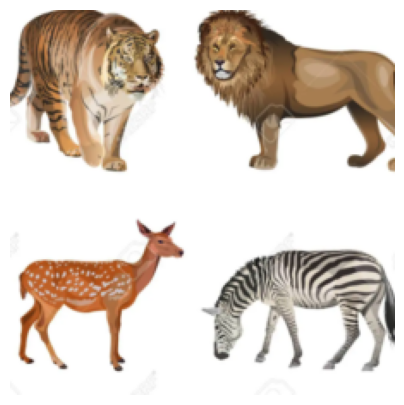

In [6]:
## load data to test
path ="./fig/ani.png"
try: 
    image = Image.open(path)
except:
    image = Image.open(path).convert('RGB')
image_trans = transform(image)

plt.figure(figsize=(5, 5))
plt.axis("off")
transform_resize = transforms.Compose([
transforms.Resize(256),transforms.CenterCrop(224),])
plt.imshow(transform_resize(image))
# plt.savefig(name, bbox_inches='tight', pad_inches=0)
output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

## Baseline Methods

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


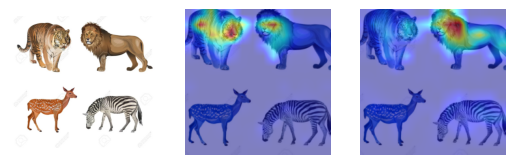

In [7]:
# VTA
# plt.title("VTA")
fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(image_trans)

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(image_trans, class_index=243)


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


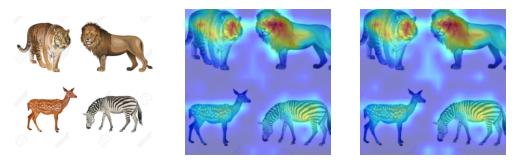

In [8]:
# raw_attn
fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(image_trans,method = "rollout")

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(image_trans, class_index=243,method = "rollout")


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


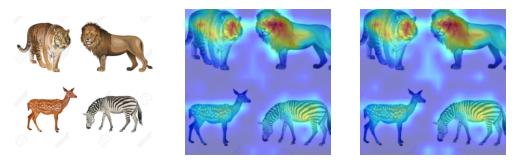

In [9]:
# rollout
fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(image_trans,method = "rollout")

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(image_trans, class_index=243,method = "rollout")


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


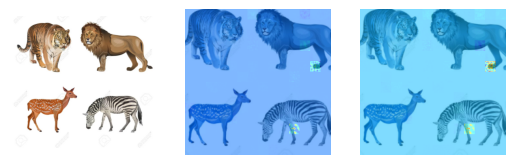

In [10]:
# full LRP
fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(image_trans,method = "full")

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(image_trans, class_index=243,method = "full")


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


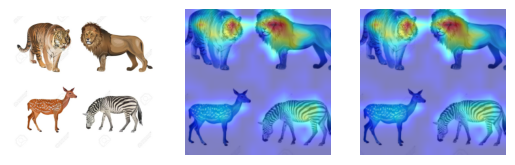

In [11]:
# partial LRP
fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(image_trans,method = "last_layer")

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(image_trans, class_index=243,method = "last_layer")


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


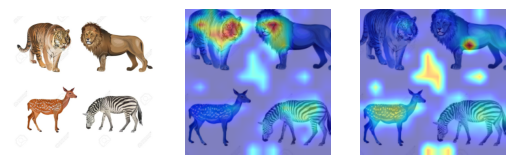

In [12]:
# attn_gradcam
fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(image_trans,method = "attn_gradcam")

# dog 
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(image_trans, class_index=243,method = "attn_gradcam")


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');
# baselines.generate_rollout(image_trans.unsqueeze(0).to(device),start_layer=1).detach()
# baselines.generate_cam_attn(image_trans.unsqueeze(0).to(device),index=243).detach()


Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


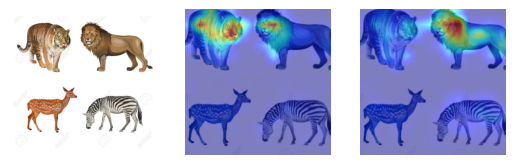

In [13]:
# ours-smooth
trial_num = 10
noise_level = 1/255

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

cat_lists = []
dog_lists = []
for i in range(trial_num):
    # cat - the predicted class
    image_trans_random_perturb = image_trans + torch.randn_like(image_trans, ) * noise_level
    cat = generate_visualization(image_trans_random_perturb,method = "transformer_attribution")

    # dog 
    # generate visualization for class 243: 'bull mastiff'
    dog = generate_visualization(image_trans_random_perturb, class_index=243,method = "transformer_attribution")

    cat_lists.append(cat)
    dog_lists.append(dog)
cat = np.mean(cat_lists,axis=0).astype(np.uint8)
dog = np.mean(dog_lists,axis=0).astype(np.uint8)
axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

/root/miniconda3/envs/fvit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


100%|██████████| 15/15 [00:01<00:00, 11.44it/s]


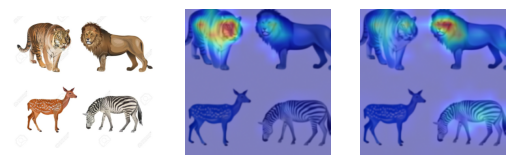

In [14]:
# ours- denoise smooth
trial_num = 10
noise_level = 5/255
opt_t = get_opt_t(noise_level, start, end, steps)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

cat_lists = []
dog_lists = []
for i in range(trial_num):
    image_trans_denoised = trans_to_224(denoise(trans_to_256(image_trans), opt_t, steps, start, end, noise_level)).detach().cpu()
    image_trans_denoise_smoothing = image_trans_denoised + torch.randn_like(image_trans, ) * noise_level
    image_trans_denoise_smoothing = torch.squeeze(image_trans_denoise_smoothing)
    image_trans_denoise_smoothing = torch.clamp(image_trans_denoise_smoothing, -1, 1)
    
    # cat - the predicted class
    cat = generate_visualization(image_trans_denoise_smoothing,method = "transformer_attribution")

    # dog 
    # generate visualization for class 243: 'bull mastiff'
    dog = generate_visualization(image_trans_denoise_smoothing, class_index=243,method = "transformer_attribution")

    cat_lists.append(cat)
    dog_lists.append(dog)
cat = np.mean(cat_lists,axis=0).astype(np.uint8)
dog = np.mean(dog_lists,axis=0).astype(np.uint8)
axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

## After being attacked

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


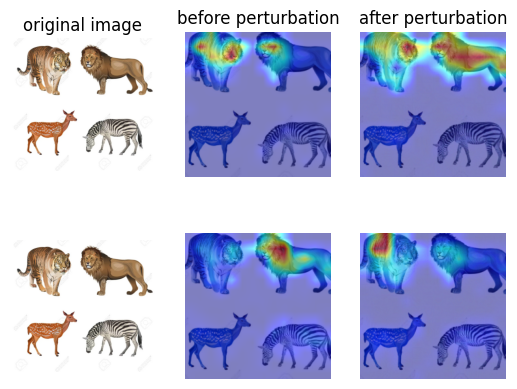

In [15]:
# # VTA
method = "vta"
fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(image);
axs[0][0].axis('off');
axs[0][0].set_title('original image')
axs[1][0].imshow(image);
axs[1][0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
image_trans_per_cat = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=282)
cat = generate_visualization(image_trans)
cat_p = generate_visualization(image_trans_per_cat.squeeze(0))

# dog 
# generate visualization for class 243: 'bull mastiff'
image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=243)
dog = generate_visualization(image_trans, class_index=243)
dog_p = generate_visualization(image_trans_per_dog.squeeze(0), class_index=243)

axs[0][1].imshow(cat);
axs[0][1].axis('off');

axs[0][1].set_title('before perturbation')
axs[0][2].imshow(cat_p);
axs[0][2].axis('off');
axs[0][2].set_title('after perturbation')

axs[1][1].imshow(dog);
axs[1][1].axis('off');
axs[1][2].imshow(dog_p);
axs[1][2].axis('off');

def save_using_plot(fig, path):
    plt.figure(figsize=(5,5))
    plt.imshow(fig)
    plt.axis('off')
    plt.savefig(path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()
    
# save using plot
noise=int(noise_level*255)
import os
if not os.path.exists(f'./fig/CatDog'):
    os.makedirs(f'./fig/CatDog')
save_using_plot(cat, f'./fig/CatDog/CatDog-{method}-cat-clean.png')
save_using_plot(dog, f'./fig/CatDog/CatDog-{method}-dog-clean.png')
save_using_plot(cat_p, f'./fig/CatDog/CatDog-{method}-cat-perturbed-{noise}.png')
save_using_plot(dog_p, f'./fig/CatDog/CatDog-{method}-dog-perturbed-{noise}.png')

100%|██████████| 15/15 [00:01<00:00, 12.05it/s]


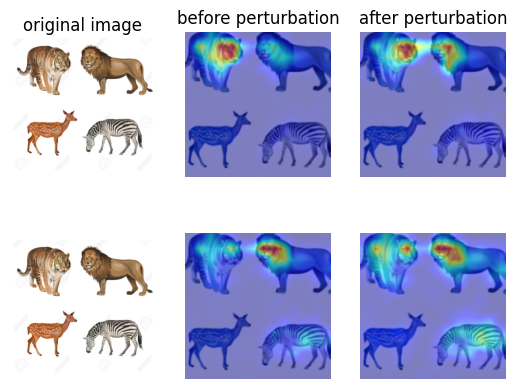

In [16]:

fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(image);
axs[0][0].axis('off');
axs[0][0].set_title('original image')
axs[1][0].imshow(image);
axs[1][0].axis('off');

# ours- denoise smooth
trial_num = 2
opt_t = get_opt_t(noise_level, start, end, steps)

cat_lists = []
dog_lists = []
catp_lists= []
dogp_lists= []
for i in range(trial_num):
    image_trans_denoised = trans_to_224(
        denoise(trans_to_256(image_trans), opt_t, steps, start, end, noise_level)
        ).detach().cpu()
    image_trans_denoise_normal = image_trans_denoised + torch.randn_like(image_trans_denoised, ) * noise_level
    image_trans_denoise_normal = torch.squeeze(image_trans_denoise_normal)
    image_trans_denoise_normal = torch.clamp(image_trans_denoise_normal, -1, 1)
    
    
    image_trans_per_cat = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=282)
    image_trans_per_cat = trans_to_224(denoise(trans_to_256(image_trans_per_cat).squeeze(0), opt_t, steps, start, end, noise_level)).detach().cpu()
    image_trans_per_cat = image_trans_per_cat + torch.randn_like(image_trans_per_cat, ) * noise_level
    image_trans_per_cat = torch.squeeze(image_trans_per_cat)
    image_trans_per_cat = torch.clamp(image_trans_per_cat, -1, 1)
    
    image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level, label_index=243)
    image_trans_per_dog = trans_to_224(denoise(trans_to_256(image_trans_per_dog).squeeze(0), opt_t, steps, start, end, noise_level)).detach().cpu()
    image_trans_per_dog = image_trans_per_dog + torch.randn_like(image_trans_per_dog, ) * noise_level
    image_trans_per_dog = torch.squeeze(image_trans_per_dog)
    image_trans_per_dog = torch.clamp(image_trans_per_dog, -1, 1)
    

    # cat - the predicted class
    cat = get_importance_maps(image_trans_denoise_normal,method = "transformer_attribution", class_index=282)
    cat_p = get_importance_maps(image_trans_per_cat.squeeze(0), class_index=282,method = "transformer_attribution")

    # dog 
    # generate visualization for class 243: 'bull mastiff'
    dog = get_importance_maps(image_trans_denoise_normal, class_index=243,method = "transformer_attribution")
    dog_p = get_importance_maps(image_trans_per_dog.squeeze(0), class_index=243,method = "transformer_attribution")

    cat_lists.append(cat)
    dog_lists.append(dog)
    catp_lists.append(cat_p)
    dogp_lists.append(dog_p)
    
cat = drop_lowest_max_fuse(cat_lists)
dog = drop_lowest_max_fuse(dog_lists)
catp = drop_lowest_max_fuse(catp_lists)
dogp = drop_lowest_max_fuse(dogp_lists)
for obji in [cat, dog, catp, dogp]:
    obji = normal(obji)

cat = show_cam_on_image_helper(image_trans_per_cat.squeeze(0), cat)
cat_p = show_cam_on_image_helper(image_trans_per_cat.squeeze(0), catp)
dog = show_cam_on_image_helper(image_trans_per_dog.squeeze(0), dog)
dog_p = show_cam_on_image_helper(image_trans_per_dog.squeeze(0), dogp)

axs[0][1].imshow(cat);
axs[0][1].axis('off');
axs[0][1].set_title('before perturbation')
axs[0][2].imshow(cat_p);
axs[0][2].axis('off');
axs[0][2].set_title('after perturbation')

axs[1][1].imshow(dog);
axs[1][1].axis('off');
axs[1][2].imshow(dog_p);
axs[1][2].axis('off');

# save using plot
method="ours"
noise=int(noise_level*255)
import os
if not os.path.exists(f'./fig/CatDog'):
    os.makedirs(f'./fig/CatDog')
save_using_plot(cat, f'./fig/CatDog/CatDog-{method}-cat-clean.png')
save_using_plot(dog, f'./fig/CatDog/CatDog-{method}-dog-clean.png')
save_using_plot(cat_p, f'./fig/CatDog/CatDog-{method}-cat-perturbed-{noise}.png')
save_using_plot(dog_p, f'./fig/CatDog/CatDog-{method}-dog-perturbed-{noise}.png')

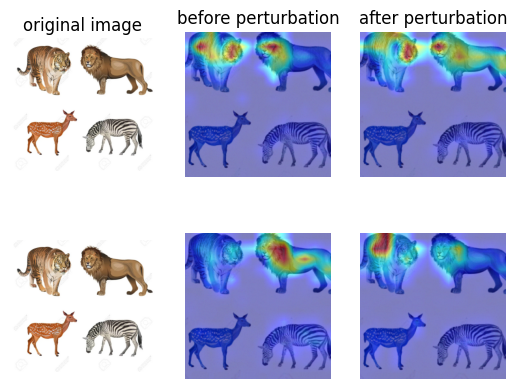

In [17]:

fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(image);
axs[0][0].axis('off');
axs[0][0].set_title('original image')
axs[1][0].imshow(image);
axs[1][0].axis('off');

# ours- without denoise
trial_num = 2
opt_t = get_opt_t(noise_level, start, end, steps)

cat_lists = []
dog_lists = []
catp_lists= []
dogp_lists= []
for i in range(trial_num):
    # image_trans_denoised = trans_to_224(
    #     denoise(trans_to_256(image_trans), opt_t, steps, start, end, noise_level)
    #     ).detach().cpu()
    image_trans_denoise_normal = image_trans + torch.randn_like(image_trans, ) * noise_level
    image_trans_denoise_normal = torch.squeeze(image_trans_denoise_normal)
    image_trans_denoise_normal = torch.clamp(image_trans_denoise_normal, -1, 1)
    
    
    image_trans_per_cat = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=282)
    # image_trans_per_cat = trans_to_224(denoise(trans_to_256(image_trans_per_cat).squeeze(0), opt_t, steps, start, end, noise_level)).detach().cpu()
    image_trans_per_cat = image_trans_per_cat + torch.randn_like(image_trans_per_cat, ) * noise_level
    image_trans_per_cat = torch.squeeze(image_trans_per_cat)
    image_trans_per_cat = torch.clamp(image_trans_per_cat, -1, 1)
    
    image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level, label_index=243)
    # image_trans_per_dog = trans_to_224(denoise(trans_to_256(image_trans_per_dog).squeeze(0), opt_t, steps, start, end, noise_level)).detach().cpu()
    image_trans_per_dog = image_trans_per_dog + torch.randn_like(image_trans_per_dog, ) * noise_level
    image_trans_per_dog = torch.squeeze(image_trans_per_dog)
    image_trans_per_dog = torch.clamp(image_trans_per_dog, -1, 1)
    
    

    # cat - the predicted class
    cat = get_importance_maps(image_trans_denoise_normal,method = "transformer_attribution", class_index=282)
    cat_p = get_importance_maps(image_trans_per_cat.squeeze(0), class_index=282,method = "transformer_attribution")

    # dog 
    # generate visualization for class 243: 'bull mastiff'
    dog = get_importance_maps(image_trans_denoise_normal, class_index=243,method = "transformer_attribution")
    dog_p = get_importance_maps(image_trans_per_dog.squeeze(0), class_index=243,method = "transformer_attribution")

    cat_lists.append(cat)
    dog_lists.append(dog)
    catp_lists.append(cat_p)
    dogp_lists.append(dog_p)
# cat = np.mean(cat_lists,axis=0)
# dog = np.mean(dog_lists,axis=0)
# catp = np.mean(catp_lists,axis=0)
# dogp = np.mean(dogp_lists,axis=0)
cat = drop_lowest_max_fuse(cat_lists)
dog = drop_lowest_max_fuse(dog_lists)
catp = drop_lowest_max_fuse(catp_lists)
dogp = drop_lowest_max_fuse(dogp_lists)

for obji in [cat, dog, catp, dogp]:
    obji = normal(obji)
    
cat = show_cam_on_image_helper(image_trans_per_cat.squeeze(0), cat)
cat_p = show_cam_on_image_helper(image_trans_per_cat.squeeze(0), catp)
dog = show_cam_on_image_helper(image_trans_per_dog.squeeze(0), dog)
dog_p = show_cam_on_image_helper(image_trans_per_dog.squeeze(0), dogp)


axs[0][1].imshow(cat);
axs[0][1].axis('off');
axs[0][1].set_title('before perturbation')
axs[0][2].imshow(cat_p);
axs[0][2].axis('off');
axs[0][2].set_title('after perturbation')

axs[1][1].imshow(dog);
axs[1][1].axis('off');
axs[1][2].imshow(dog_p);
axs[1][2].axis('off');

# save using plot
method="ours-without-denoise"
noise=int(noise_level*255)
import os
if not os.path.exists(f'./fig/CatDog'):
    os.makedirs(f'./fig/CatDog')
save_using_plot(cat, f'./fig/CatDog/CatDog-{method}-cat-clean.png')
save_using_plot(dog, f'./fig/CatDog/CatDog-{method}-dog-clean.png')
save_using_plot(cat_p, f'./fig/CatDog/CatDog-{method}-cat-perturbed-{noise}.png')
save_using_plot(dog_p, f'./fig/CatDog/CatDog-{method}-dog-perturbed-{noise}.png')

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00, 12.07it/s]


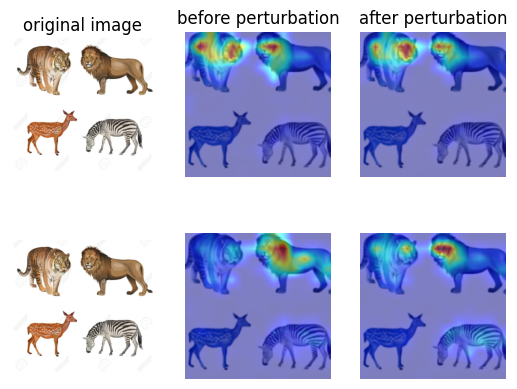

In [18]:

fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(image);
axs[0][0].axis('off');
axs[0][0].set_title('original image')
axs[1][0].imshow(image);
axs[1][0].axis('off');

# ours- only denoise
trial_num = 2
opt_t = get_opt_t(noise_level, start, end, steps)

cat_lists = []
dog_lists = []
catp_lists= []
dogp_lists= []
for i in range(trial_num):
    image_trans_denoised = trans_to_224(
        denoise(trans_to_256(image_trans), opt_t, steps, start, end, noise_level)
        ).detach().cpu()
    # image_trans_denoise_normal = image_trans_denoised + torch.randn_like(image_trans_denoised, ) * noise_level
    image_trans_denoise_normal = torch.squeeze(image_trans_denoise_normal)
    image_trans_denoise_normal = torch.clamp(image_trans_denoise_normal, -1, 1)
    
    
    image_trans_per_cat = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=282)
    image_trans_per_cat = trans_to_224(denoise(trans_to_256(image_trans_per_cat).squeeze(0), opt_t, steps, start, end, noise_level)).detach().cpu()
    # image_trans_per_cat = image_trans_per_cat + torch.randn_like(image_trans_per_cat, ) * noise_level
    image_trans_per_cat = torch.squeeze(image_trans_per_cat)
    image_trans_per_cat = torch.clamp(image_trans_per_cat, -1, 1)
    
    image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level, label_index=243)
    image_trans_per_dog = trans_to_224(denoise(trans_to_256(image_trans_per_dog).squeeze(0), opt_t, steps, start, end, noise_level)).detach().cpu()
    # image_trans_per_dog = image_trans_per_dog + torch.randn_like(image_trans_per_dog, ) * noise_level
    image_trans_per_dog = torch.squeeze(image_trans_per_dog)
    image_trans_per_dog = torch.clamp(image_trans_per_dog, -1, 1)
    
    
    # cat - the predicted class
    cat = get_importance_maps(image_trans_denoise_normal,method = "transformer_attribution", class_index=282)
    cat_p = get_importance_maps(image_trans_per_cat.squeeze(0), class_index=282,method = "transformer_attribution")

    # dog 
    # generate visualization for class 243: 'bull mastiff'
    dog = get_importance_maps(image_trans_denoise_normal, class_index=243,method = "transformer_attribution")
    dog_p = get_importance_maps(image_trans_per_dog.squeeze(0), class_index=243,method = "transformer_attribution")

    cat_lists.append(cat)
    dog_lists.append(dog)
    catp_lists.append(cat_p)
    dogp_lists.append(dog_p)
cat = drop_lowest_max_fuse(cat_lists)
dog = drop_lowest_max_fuse(dog_lists)
catp = drop_lowest_max_fuse(catp_lists)
dogp = drop_lowest_max_fuse(dogp_lists)
for obji in [cat, dog, catp, dogp]:
    obji = normal(obji)
cat = show_cam_on_image_helper(image_trans_per_cat.squeeze(0), cat)
cat_p = show_cam_on_image_helper(image_trans_per_cat.squeeze(0), catp)
dog = show_cam_on_image_helper(image_trans_per_dog.squeeze(0), dog)
dog_p = show_cam_on_image_helper(image_trans_per_dog.squeeze(0), dogp)

axs[0][1].imshow(cat);
axs[0][1].axis('off');
axs[0][1].set_title('before perturbation')
axs[0][2].imshow(cat_p);
axs[0][2].axis('off');
axs[0][2].set_title('after perturbation')

axs[1][1].imshow(dog);
axs[1][1].axis('off');
axs[1][2].imshow(dog_p);
axs[1][2].axis('off');

# save using plot
method="ours-only-denoise"
noise=int(noise_level*255)
import os
if not os.path.exists(f'./fig/CatDog'):
    os.makedirs(f'./fig/CatDog')
save_using_plot(cat, f'./fig/CatDog/CatDog-{method}-cat-clean.png')
save_using_plot(dog, f'./fig/CatDog/CatDog-{method}-dog-clean.png')
save_using_plot(cat_p, f'./fig/CatDog/CatDog-{method}-cat-perturbed-{noise}.png')
save_using_plot(dog_p, f'./fig/CatDog/CatDog-{method}-dog-perturbed-{noise}.png')


Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


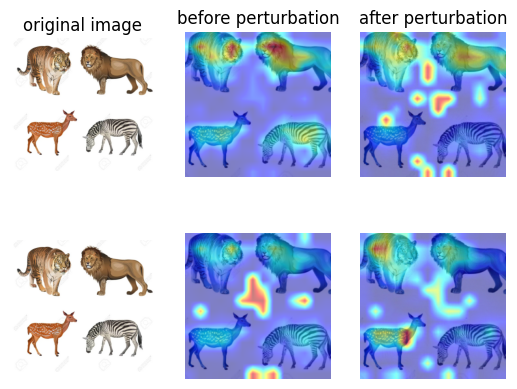

In [19]:
# raw_attn
fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(image);
axs[0][0].axis('off');
axs[0][0].set_title('original image')
axs[1][0].imshow(image);
axs[1][0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
image_trans_per_cat = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=282)
cat = generate_visualization(image_trans,method = "rollout")
cat_p = generate_visualization(image_trans_per_cat.squeeze(0),method = "last_layer_attn")

# dog 
# generate visualization for class 243: 'bull mastiff'
image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=243)
dog = generate_visualization(image_trans, class_index=243,method = "last_layer_attn")
dog_p = generate_visualization(image_trans_per_dog.squeeze(0), method = "last_layer_attn", class_index=243)


axs[0][1].imshow(cat);
axs[0][1].axis('off');
axs[0][1].set_title('before perturbation')
axs[0][2].imshow(cat_p);
axs[0][2].axis('off');
axs[0][2].set_title('after perturbation')

axs[1][1].imshow(dog);
axs[1][1].axis('off');
axs[1][2].imshow(dog_p);
axs[1][2].axis('off');

# save using plot
method="raw_attn"
noise=int(noise_level*255)
import os
if not os.path.exists(f'./fig/CatDog'):
    os.makedirs(f'./fig/CatDog')
save_using_plot(cat, f'./fig/CatDog/CatDog-{method}-cat-clean.png')
save_using_plot(dog, f'./fig/CatDog/CatDog-{method}-dog-clean.png')
save_using_plot(cat_p, f'./fig/CatDog/CatDog-{method}-cat-perturbed-{noise}.png')
save_using_plot(dog_p, f'./fig/CatDog/CatDog-{method}-dog-perturbed-{noise}.png')

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


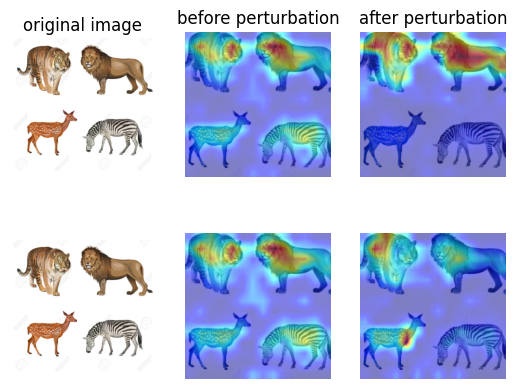

In [20]:
# "rollout"
fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(image);
axs[0][0].axis('off');
axs[0][0].set_title('original image')
axs[1][0].imshow(image);
axs[1][0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
image_trans_per_cat = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=282)
cat = generate_visualization(image_trans,method = "rollout")
cat_p = generate_visualization(image_trans_per_cat.squeeze(0),method = "rollout")

# dog 
# generate visualization for class 243: 'bull mastiff'
image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=243)
dog = generate_visualization(image_trans, class_index=243,method = "rollout")
dog_p = generate_visualization(image_trans_per_dog.squeeze(0), method = "rollout", class_index=243)


axs[0][1].imshow(cat);
axs[0][1].axis('off');
axs[0][1].set_title('before perturbation')
axs[0][2].imshow(cat_p);
axs[0][2].axis('off');
axs[0][2].set_title('after perturbation')

axs[1][1].imshow(dog);
axs[1][1].axis('off');
axs[1][2].imshow(dog_p);
axs[1][2].axis('off');

# save using plot
method="rollout"
noise=int(noise_level*255)
import os
if not os.path.exists(f'./fig/CatDog'):
    os.makedirs(f'./fig/CatDog')
save_using_plot(cat, f'./fig/CatDog/CatDog-{method}-cat-clean.png')
save_using_plot(dog, f'./fig/CatDog/CatDog-{method}-dog-clean.png')
save_using_plot(cat_p, f'./fig/CatDog/CatDog-{method}-cat-perturbed-{noise}.png')
save_using_plot(dog_p, f'./fig/CatDog/CatDog-{method}-dog-perturbed-{noise}.png')

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


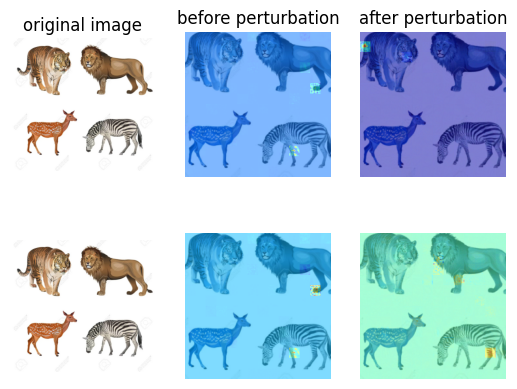

In [21]:
# "full"
fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(image);
axs[0][0].axis('off');
axs[0][0].set_title('original image')
axs[1][0].imshow(image);
axs[1][0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
image_trans_per_cat = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=282)
cat = generate_visualization(image_trans,method = "full")
cat_p = generate_visualization(image_trans_per_cat.squeeze(0),method = "full")

# dog 
# generate visualization for class 243: 'bull mastiff'
image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=243)
dog = generate_visualization(image_trans, class_index=243,method = "full")
dog_p = generate_visualization(image_trans_per_dog.squeeze(0), method = "full", class_index=243)


axs[0][1].imshow(cat);
axs[0][1].axis('off');
axs[0][1].set_title('before perturbation')
axs[0][2].imshow(cat_p);
axs[0][2].axis('off');
axs[0][2].set_title('after perturbation')

axs[1][1].imshow(dog);
axs[1][1].axis('off');
axs[1][2].imshow(dog_p);
axs[1][2].axis('off');

# save using plot
method="full-LRP"
noise=int(noise_level*255)
import os
if not os.path.exists(f'./fig/CatDog'):
    os.makedirs(f'./fig/CatDog')
save_using_plot(cat, f'./fig/CatDog/CatDog-{method}-cat-clean.png')
save_using_plot(dog, f'./fig/CatDog/CatDog-{method}-dog-clean.png')
save_using_plot(cat_p, f'./fig/CatDog/CatDog-{method}-cat-perturbed-{noise}.png')
save_using_plot(dog_p, f'./fig/CatDog/CatDog-{method}-dog-perturbed-{noise}.png')

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


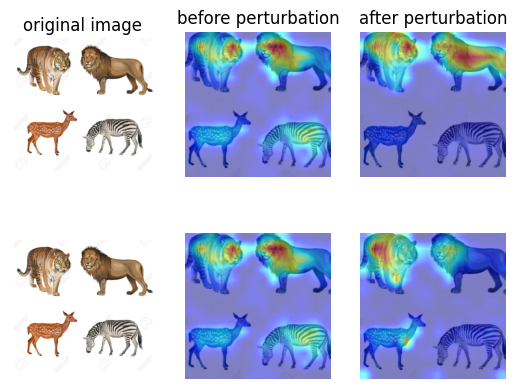

In [22]:
# "part"
fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(image);
axs[0][0].axis('off');
axs[0][0].set_title('original image')
axs[1][0].imshow(image);
axs[1][0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
image_trans_per_cat = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=282)
cat = generate_visualization(image_trans,method = "last_layer")
cat_p = generate_visualization(image_trans_per_cat.squeeze(0),method = "last_layer")

# dog 
# generate visualization for class 243: 'bull mastiff'
image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=243)
dog = generate_visualization(image_trans, class_index=243,method = "last_layer")
dog_p = generate_visualization(image_trans_per_dog.squeeze(0), method = "last_layer", class_index=243)


axs[0][1].imshow(cat);
axs[0][1].axis('off');
axs[0][1].set_title('before perturbation')
axs[0][2].imshow(cat_p);
axs[0][2].axis('off');
axs[0][2].set_title('after perturbation')

axs[1][1].imshow(dog);
axs[1][1].axis('off');
axs[1][2].imshow(dog_p);
axs[1][2].axis('off');


# save using plot
method="part-LRP"
noise=int(noise_level*255)
import os
if not os.path.exists(f'./fig/CatDog'):
    os.makedirs(f'./fig/CatDog')
save_using_plot(cat, f'./fig/CatDog/CatDog-{method}-cat-clean.png')
save_using_plot(dog, f'./fig/CatDog/CatDog-{method}-dog-clean.png')
save_using_plot(cat_p, f'./fig/CatDog/CatDog-{method}-cat-perturbed-{noise}.png')
save_using_plot(dog_p, f'./fig/CatDog/CatDog-{method}-dog-perturbed-{noise}.png')

Top 5 classes:
	292 : tiger, Panthera tigris            		value = 11.300	 prob = 84.7%
	282 : tiger cat                         		value = 8.113	 prob = 3.5%
	291 : lion, king of beasts, Panthera leo		value = 7.861	 prob = 2.7%
	340 : zebra                             		value = 7.704	 prob = 2.3%
	274 : dhole, Cuon alpinus               		value = 7.022	 prob = 1.2%


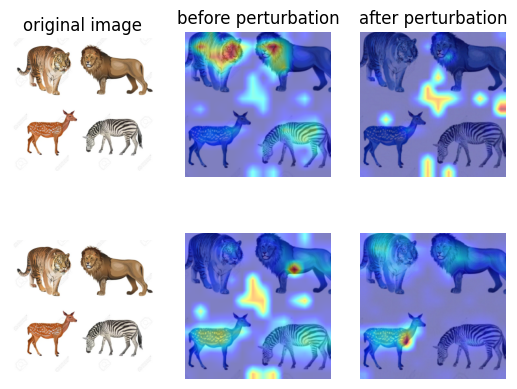

In [23]:
# "attn_gradcam"
fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(image);
axs[0][0].axis('off');
axs[0][0].set_title('original image')
axs[1][0].imshow(image);
axs[1][0].axis('off');

output = model(image_trans.unsqueeze(0).to(device))
print_top_classes(output)

# cat - the predicted class
image_trans_per_cat = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=282)
cat = generate_visualization(image_trans,method = "attn_gradcam")
cat_p = generate_visualization(image_trans_per_cat.squeeze(0),method = "attn_gradcam")

# dog 
# generate visualization for class 243: 'bull mastiff'
image_trans_per_dog = attack(image_trans.unsqueeze(0).to(device), model, noise_level,label_index=243)
dog = generate_visualization(image_trans, class_index=243,method = "attn_gradcam")
dog_p = generate_visualization(image_trans_per_dog.squeeze(0), method = "attn_gradcam", class_index=243)


axs[0][1].imshow(cat);
axs[0][1].axis('off');
axs[0][1].set_title('before perturbation')
axs[0][2].imshow(cat_p);
axs[0][2].axis('off');
axs[0][2].set_title('after perturbation')

axs[1][1].imshow(dog);
axs[1][1].axis('off');
axs[1][2].imshow(dog_p);
axs[1][2].axis('off');

# save using plot
method="attn_gradcam"
noise=int(noise_level*255)
import os
if not os.path.exists(f'./fig/CatDog'):
    os.makedirs(f'./fig/CatDog')
save_using_plot(cat, f'./fig/CatDog/CatDog-{method}-cat-clean.png')
save_using_plot(dog, f'./fig/CatDog/CatDog-{method}-dog-clean.png')
save_using_plot(cat_p, f'./fig/CatDog/CatDog-{method}-cat-perturbed-{noise}.png')
save_using_plot(dog_p, f'./fig/CatDog/CatDog-{method}-dog-perturbed-{noise}.png')